In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from scipy.stats import norm

from copy import deepcopy
import itertools
import random

from collections import OrderedDict


import torch
import torch.nn as nn


from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

seed_everything(0)


blue = '#0073B7'
yellow = '#FFD23F'
gray = '#7A7A7A'
purple = '#B05AA3'
green = '#00A651'
orange = '#F7941D'


blue_yellow = LinearSegmentedColormap.from_list(
    "blue_yellow", ["#0073B7", "#FFD23F"]
)


gray = '#C0C0C0'
purple = '#B05AA3'

gray_purple = LinearSegmentedColormap.from_list(
    "gray_purple",
    [gray , purple]
)


import os
import multiprocessing


os.environ["OMP_NUM_THREADS"]="1"
os.environ["MKL_NUM_THREADS"]="1"
os.environ["OPENBLAS_NUM_THREADS"]="1"
os.environ["NUMEXPR_NUM_THREADS"]="1"
os.environ["MKL_DYNAMIC"]="FALSE"
torch.set_num_threads(1)
torch.set_num_interop_threads(1)
multiprocessing.set_start_method("fork")

In [2]:
from src.model import SSCNetwork
from params.default import network_parameters, recording_parameters, latent_specs, input_parameters
from network_model.forward import forward
from src.utils.general import make_input, LatentSpace, get_ordered_indices, test_network, get_latent_accuracy, get_signal_to_noise_ratio, get_cond_matrix

from src.utils.Figure_3 import figure3_recall

In [3]:
network_parameters["hidden_num_subregions"] = 2
network_parameters["hidden_size_subregions"] = torch.tensor([50, 100])
network_parameters["hidden_sparsity"] = torch.tensor([10/50, 10/100])
network_parameters["hidden_sparsity_sleep"] = torch.tensor([10/50, 10/100])

network_parameters["frozen"] = False
network_model = {}
network_model["forward"] = forward

recording_parameters["rate_connectivity"] = 1

input_parameters["day_length"] = 25000

latent_specs = {}
latent_specs["num"] = 2
latent_specs["total_sizes"] = [50, 100]
latent_specs["act_sizes"] = [10, 10]
latent_specs["dims"] = [5, 10]
latent_specs["prob_list"] = [1/10 if j//2==i else 0 for i in range(5) for j in range(10)]
input_parameters["latent_space"] = LatentSpace(**latent_specs)

In [4]:
seed_everything(0)
network = SSCNetwork(network_parameters, recording_parameters, network_model)
network_hidden_hidden_0 = network.hidden_hidden.T
input, input_episodes, input_latents = make_input(**input_parameters, regions=network.hidden_subregions)

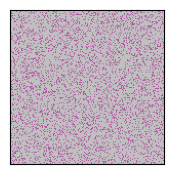

In [5]:
fit = plt.figure(figsize=(2,2))

plt.imshow(network.hidden_hidden, cmap=gray_purple)
plt.xticks([])
plt.yticks([])

plt.savefig("Figures/SVG/3B11.svg", dpi=300, transparent=True)

In [6]:
print_rate = 50
with torch.no_grad():
    for day in range(input_parameters["num_days"]):
        if day%print_rate == 0:
            print(day)
        network(input[day], debug=False)

0


In [7]:
sim_cond_matrix, th_cond_matrix = get_cond_matrix(input_parameters["latent_space"], np.array(network.hidden_hidden), 1)
th_cond_matrix = np.repeat(np.repeat(th_cond_matrix, 10, axis=0), 10, axis=1).flatten()

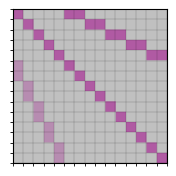

In [9]:
fit = plt.figure(figsize=(2,2))

# Set ticks at pixel boundaries
plt.xticks(np.arange(-0.5, 150, 10), minor=True)
plt.yticks(np.arange(-0.5, 150, 10), minor=True)
plt.grid(which="minor", color="black", linestyle='-', linewidth=0.1)

plt.imshow(th_cond_matrix.reshape((150, 150)), cmap=gray_purple)
plt.xticks([])
plt.yticks([])

plt.savefig("Figures/SVG/3B12.svg", dpi=300, transparent=True)

In [10]:
hidden_hidden = np.array(network.connectivity_recordings["hidden_hidden"]).reshape(25001, -1)

In [11]:
# Normalize
A_norm =  hidden_hidden/ np.linalg.norm(hidden_hidden, axis=1, keepdims=True)
b_norm = th_cond_matrix / np.linalg.norm(th_cond_matrix)

# Cosine similarity
cos_sim_outgoing = A_norm @ b_norm  # shape (T,)

In [12]:
random_sample = torch.randperm(hidden_hidden.shape[1])[:300]

random_sample_j = random_sample % network.hidden_size


tau_higher_order = 1/(5e-5*20*0.2)
tau_lower_order  = 1/(5e-5*20*0.1)

predicted_trajs_higher_order = np.outer(hidden_hidden[0][random_sample][random_sample_j < 50], np.exp(-np.arange(25000)/tau_higher_order)) +  np.outer(0.05*th_cond_matrix[random_sample][random_sample_j < 50], 1 - np.exp(-np.arange(25000)/tau_higher_order))
predicted_trajs_lower_order = np.outer(hidden_hidden[0][random_sample][random_sample_j >= 50], np.exp(-np.arange(25000)/tau_lower_order)) +  np.outer(0.05*th_cond_matrix[random_sample][random_sample_j >= 50], 1 - np.exp(-np.arange(25000)/tau_lower_order))

predicted_trajs = np.concatenate((predicted_trajs_higher_order, predicted_trajs_lower_order))

/var/folders/jp/4cgfm60j5y9bnfwq3whjps6m0000gn/T/ipykernel_1573/1130316882.py:20: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig("Figures/SVG/3C1.svg", dpi=300, transparent=True)
/Users/albertalbesagonzalez/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


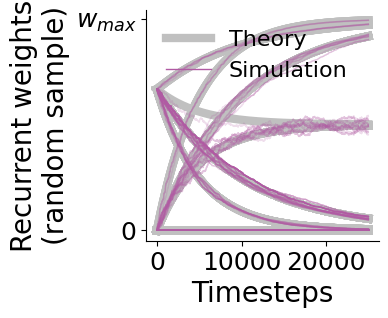

In [13]:
fit = plt.figure(figsize=(3, 3))

for traj in predicted_trajs:
    plt.plot(traj, alpha=1, color=gray, linewidth=6)
plt.plot(traj, alpha=1, color=gray, linewidth=6, label="Theory")

for sample in random_sample:
    plt.plot(hidden_hidden[1:, sample], color=purple, alpha=0.2, linewidth=1)
plt.plot(hidden_hidden[1:, sample], color=purple, alpha=1, linewidth=1, label="Simulation")


plt.xlabel("Timesteps", fontsize=20)
plt.ylabel("Recurrent weights\n(random sample)", fontsize=20)
plt.xticks([0, 10000, 20000], fontsize=18)
plt.yticks([0, 0.05], [0, r"$w_{max}$"], fontsize=18)

plt.legend(frameon=False, fontsize=16)
sns.despine()

plt.savefig("Figures/SVG/3C1.svg", dpi=300, transparent=True)

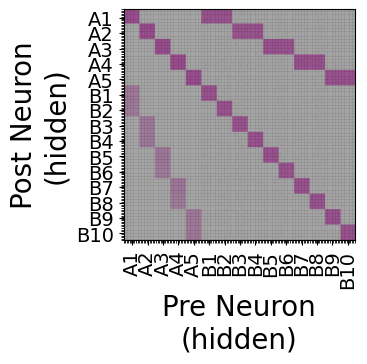

In [14]:
fit = plt.figure(figsize=(3,3))

plt.imshow(network.hidden_hidden, cmap=gray_purple)

plt.xticks(np.arange(-0.5, 150, 1), minor=True)
plt.yticks(np.arange(-0.5, 150, 1), minor=True)
plt.grid(which='minor', color='black', linestyle='-', linewidth=0.1)
plt.xticks([])
plt.yticks([])

# Example parameters
N = 150  # Total number of y-axis ticks (from 0 to N)
NA = 5   # Number of A groups
NB = 10  # Number of B groups
M = N // (NA + NB)  # Size of each group (equal-sized labels)

# Generate labels
labels_A = [f"A{i+1}" for i in range(NA)]
labels_B = [f"B{i+1}" for i in range(NB)]
labels = labels_A + labels_B

# Positions for labels (centered in each segment)
positions = [M * (i + 0.5) for i in range(NA + NB)]
plt.xticks(positions, labels,  fontsize=14, rotation=90)
plt.yticks(positions, labels, fontsize=14)
plt.ylabel("Post Neuron\n(hidden)", fontsize=20)
plt.xlabel("Pre Neuron\n(hidden)", fontsize=20)

plt.savefig("Figures/SVG/3C2.svg", dpi=300, transparent=True)

In [37]:
num_cpu = 8
num_episodes = 5000
num_swaps_train_list = np.arange(0, 21, 4)
num_swaps_test_list = np.arange(0, 21, 4)
snr_list = [get_signal_to_noise_ratio(num_swaps, network) for num_swaps in num_swaps_train_list]
num_seeds = 1
seeds = np.arange(num_seeds)
seeds = [int(s) for s in np.asarray(seeds).ravel().tolist()]

In [38]:

experiment_params = [(network_parameters, network_model, recording_parameters, input_parameters, latent_specs, num_episodes, num_swaps_input, num_swaps_recall, seed) for num_swaps_input in num_swaps_train_list for num_swaps_recall in num_swaps_test_list for seed in seeds]
pool = multiprocessing.Pool(processes=num_cpu)

results = np.array(pool.starmap(figure3_recall, experiment_params))

Starting Figure 3 recall - seed0, noise_in0, noise_rec8Starting Figure 3 recall - seed0, noise_in0, noise_rec0Starting Figure 3 recall - seed0, noise_in0, noise_rec16Starting Figure 3 recall - seed0, noise_in4, noise_rec0


Starting Figure 3 recall - seed0, noise_in4, noise_rec8
Starting Figure 3 recall - seed0, noise_in4, noise_rec16Starting Figure 3 recall - seed0, noise_in8, noise_rec0

Starting Figure 3 recall - seed0, noise_in8, noise_rec8

Starting Figure 3 recall - seed0, noise_in4, noise_rec12Starting Figure 3 recall - seed0, noise_in4, noise_rec4Starting Figure 3 recall - seed0, noise_in0, noise_rec4Starting Figure 3 recall - seed0, noise_in0, noise_rec20Starting Figure 3 recall - seed0, noise_in0, noise_rec12




Starting Figure 3 recall - seed0, noise_in4, noise_rec20
Starting Figure 3 recall - seed0, noise_in8, noise_rec12
Starting Figure 3 recall - seed0, noise_in8, noise_rec4
Starting Figure 3 recall - seed0, noise_in8, noise_rec16
Starting Figure 3 recall - seed0, noise_

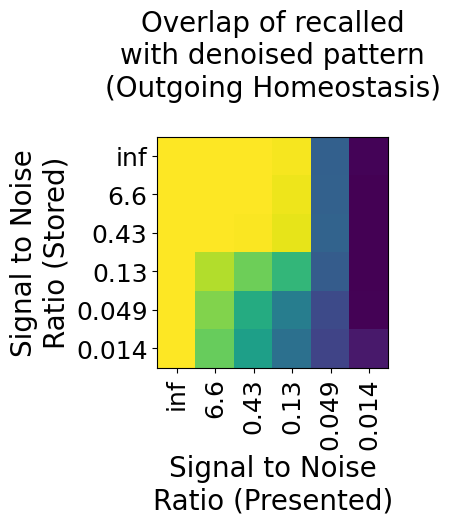

In [39]:
snr_labels = [f"{x:.2g}" for x in snr_list]


fig = plt.figure(figsize=(3, 3))

plt.title("Overlap of recalled\nwith denoised pattern\n(Outgoing Homeostasis)\n", fontsize=20)

plt.imshow(results.reshape(len(snr_list), len(snr_list), 2)[:, :, 0])
plt.ylabel("Signal to Noise\nRatio (Stored)", fontsize=20)
plt.xlabel("Signal to Noise\nRatio (Presented)", fontsize=20)
plt.xticks(np.arange(len(snr_labels)), snr_labels, fontsize=18, rotation=90)
plt.yticks(np.arange(len(snr_labels)), snr_labels, fontsize=18)

plt.savefig("Figures/SVG/3F1.svg", dpi=300, transparent=True)

In [40]:
network_parameters["max_pre_hidden_hidden"] = np.inf
network_parameters["max_post_hidden_hidden"] = 1

network_parameters["hidden_hidden_init_random_max"] = "post"
network_parameters["hidden_hidden_init_max_post"] = 1

In [41]:
input, input_episodes, input_latents = make_input(**input_parameters, regions=network.hidden_subregions)
network = SSCNetwork(network_parameters, recording_parameters, network_model)

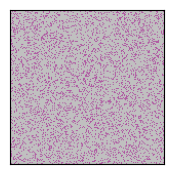

In [42]:
fit = plt.figure(figsize=(2,2))

plt.imshow(network.hidden_hidden, cmap=gray_purple)
plt.xticks([])
plt.yticks([])

plt.savefig("Figures/SVG/3B22.svg", dpi=300, transparent=True)

In [43]:
print_rate = 50
with torch.no_grad():
    for day in range(input_parameters["num_days"]):
        if day%print_rate == 0:
            print(day)
        network(input[day], debug=False)

0


In [44]:
sim_cond_matrix, th_cond_matrix = get_cond_matrix(input_parameters["latent_space"], np.array(network.hidden_hidden), 1)
th_cond_matrix = (np.repeat(np.repeat(th_cond_matrix, 10, axis=0), 10, axis=1).flatten()).reshape((150, 150)).T.flatten()

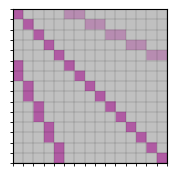

In [46]:
fit = plt.figure(figsize=(2,2))

# Set ticks at pixel boundaries
plt.xticks(np.arange(-0.5, 150, 10), minor=True)
plt.yticks(np.arange(-0.5, 150, 10), minor=True)
plt.grid(which="minor", color="black", linestyle='-', linewidth=0.1)

plt.imshow(th_cond_matrix.reshape((150, 150)), cmap=gray_purple)
plt.xticks([])
plt.yticks([])

plt.savefig("Figures/SVG/3B22.svg", dpi=300, transparent=True)

In [47]:
hidden_hidden = np.array(network.connectivity_recordings["hidden_hidden"]).reshape(25001, -1)

In [48]:
random_sample = torch.randperm(10000)[:300]

random_sample_i = random_sample // network.hidden_size

tau_higher_order = 1/(5e-5*20*0.2)
tau_lower_order  = 1/(5e-5*20*0.1)

predicted_trajs_higher_order = np.outer(hidden_hidden[2][random_sample][random_sample_i < 50], np.exp(-np.arange(25000)/tau_higher_order)) +  np.outer(0.05*th_cond_matrix[random_sample][random_sample_i < 50], 1 - np.exp(-np.arange(25000)/tau_higher_order))
predicted_trajs_lower_order = np.outer(hidden_hidden[2][random_sample][random_sample_i >= 50], np.exp(-np.arange(25000)/tau_lower_order)) +  np.outer(0.05*th_cond_matrix[random_sample][random_sample_i >= 50], 1 - np.exp(-np.arange(25000)/tau_lower_order))

predicted_trajs = np.concatenate((predicted_trajs_higher_order, predicted_trajs_lower_order))

/var/folders/jp/4cgfm60j5y9bnfwq3whjps6m0000gn/T/ipykernel_1573/2925583839.py:27: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig("Figures/SVG/3D1.svg", dpi=300, transparent=True)
/Users/albertalbesagonzalez/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


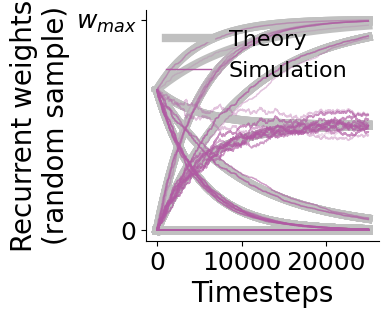

In [49]:
fit = plt.figure(figsize=(3, 3))

for traj in predicted_trajs:
    plt.plot(traj, alpha=1, color=gray, linewidth=6)

plt.plot(traj, alpha=1, color=gray, linewidth=6, label="Theory")


for sample in random_sample:
    plt.plot(hidden_hidden[1:, sample], color=purple, alpha=0.2, linewidth=1)

plt.plot(hidden_hidden[1:, sample], color=purple, alpha=1, linewidth=1, label="Simulation")


plt.xlabel("Timesteps", fontsize=20)
plt.ylabel("Recurrent weights\n(random sample)", fontsize=20)


plt.xticks([0, 10000, 20000], fontsize=18)
plt.yticks([0, 0.05], [0, r"$w_{max}$"], fontsize=18)


plt.legend(frameon=False, fontsize=16)

sns.despine()

plt.savefig("Figures/SVG/3D1.svg", dpi=300, transparent=True)

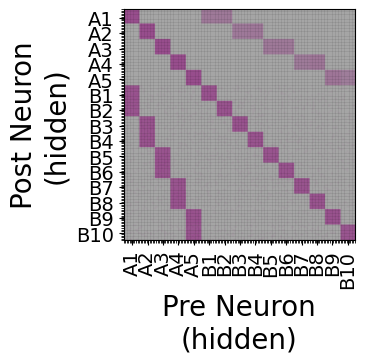

In [50]:
fit = plt.figure(figsize=(3,3))

plt.imshow(network.hidden_hidden, cmap=gray_purple)

plt.xticks(np.arange(-0.5, 150, 1), minor=True)
plt.yticks(np.arange(-0.5, 150, 1), minor=True)
plt.grid(which='minor', color='black', linestyle='-', linewidth=0.1)
plt.xticks([])
plt.yticks([])

# Example parameters
N = 150  # Total number of y-axis ticks (from 0 to N)
NA = 5   # Number of A groups
NB = 10  # Number of B groups
M = N // (NA + NB)  # Size of each group (equal-sized labels)

# Generate labels
labels_A = [f"A{i+1}" for i in range(NA)]
labels_B = [f"B{i+1}" for i in range(NB)]
labels = labels_A + labels_B

# Positions for labels (centered in each segment)
positions = [M * (i + 0.5) for i in range(NA + NB)]
plt.xticks(positions, labels,  fontsize=14, rotation=90)
plt.yticks(positions, labels, fontsize=14)
plt.ylabel("Post Neuron\n(hidden)", fontsize=20)
plt.xlabel("Pre Neuron\n(hidden)", fontsize=20)

plt.savefig("Figures/SVG/3D2.svg", dpi=300, transparent=True)

In [51]:
# Normalize
A_norm =  hidden_hidden/ np.linalg.norm(hidden_hidden, axis=1, keepdims=True)
b_norm = th_cond_matrix.flatten() / np.linalg.norm(th_cond_matrix.flatten())

# Cosine similarity
cos_sim_incoming = A_norm @ b_norm  # shape (T,)

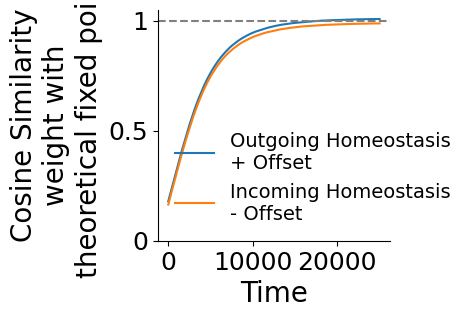

In [52]:
fig = plt.figure(figsize=(3, 3))

plt.plot(cos_sim_outgoing+0.01, label="Outgoing Homeostasis\n+ Offset")
plt.plot(cos_sim_incoming-0.01, label ="Incoming Homeostasis\n- Offset")

plt.ylabel("Cosine Similarity\nweight with\ntheoretical fixed point", fontsize=20)
plt.xlabel("Time", fontsize=20)

plt.yticks([0, 0.5, 1], [0, 0.5, 1], fontsize=18)
plt.xticks([0, 10000, 20000], fontsize=18)

sns.despine()

plt.axhline(1, linestyle="dashed", color='grey')

plt.legend(fontsize=14, frameon=False)

plt.savefig("Figures/SVG/3E.svg", dpi=300, transparent=True)

In [53]:
recording_parameters = {}
recording_parameters["regions"] = ["hidden"]
recording_parameters["rate_activity"] = 1
recording_parameters["connections"] = []
recording_parameters["rate_connectivity"] = np.inf

In [55]:
num_cpu = 8
num_episodes = 5000
num_swaps_train_list = np.arange(0, 21, 4)
num_swaps_test_list = np.arange(0, 21, 4)
snr_list = [get_signal_to_noise_ratio(num_swaps, network) for num_swaps in num_swaps_train_list]
num_seeds = 1
seeds = np.arange(num_seeds)
seeds = [int(s) for s in np.asarray(seeds).ravel().tolist()]

In [56]:
experiment_params = [(network_parameters, network_model, recording_parameters, input_parameters, latent_specs, num_episodes, num_swaps_recall, num_swaps_input, seed) for num_swaps_recall in num_swaps_train_list for num_swaps_input in num_swaps_test_list for seed in seeds]
pool = multiprocessing.Pool(processes=num_cpu)

results = np.array(pool.starmap(figure3_recall, experiment_params))

Starting Figure 3 recall - seed0, noise_in0, noise_rec0Starting Figure 3 recall - seed0, noise_in0, noise_rec16Starting Figure 3 recall - seed0, noise_in4, noise_rec0Starting Figure 3 recall - seed0, noise_in0, noise_rec8

Starting Figure 3 recall - seed0, noise_in4, noise_rec8


Starting Figure 3 recall - seed0, noise_in4, noise_rec16
Starting Figure 3 recall - seed0, noise_in8, noise_rec0Starting Figure 3 recall - seed0, noise_in8, noise_rec8

Starting Figure 3 recall - seed0, noise_in0, noise_rec12
Starting Figure 3 recall - seed0, noise_in0, noise_rec20
Starting Figure 3 recall - seed0, noise_in4, noise_rec12Starting Figure 3 recall - seed0, noise_in4, noise_rec20

Starting Figure 3 recall - seed0, noise_in0, noise_rec4Starting Figure 3 recall - seed0, noise_in8, noise_rec4

Starting Figure 3 recall - seed0, noise_in4, noise_rec4Starting Figure 3 recall - seed0, noise_in8, noise_rec12

Starting Figure 3 recall - seed0, noise_in8, noise_rec16
Starting Figure 3 recall - seed0, noise_

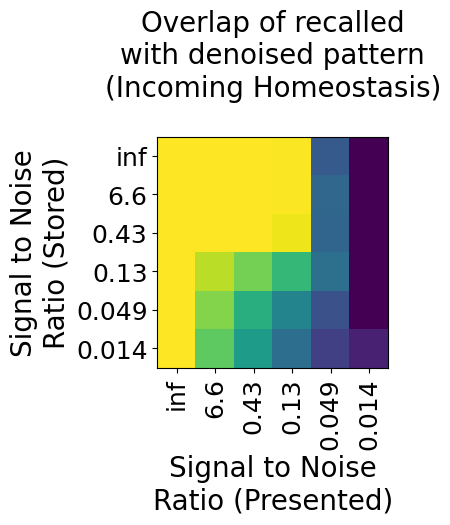

In [57]:
snr_labels = [f"{x:.2g}" for x in snr_list]

fig = plt.figure(figsize=(3, 3))

plt.title("Overlap of recalled\nwith denoised pattern\n(Incoming Homeostasis)\n", fontsize=20)

plt.imshow(results.reshape(len(snr_list), len(snr_list), 2)[:, :, 0])

plt.ylabel("Signal to Noise\nRatio (Stored)", fontsize=20)
plt.xlabel("Signal to Noise\nRatio (Presented)", fontsize=20)
plt.xticks(np.arange(len(snr_labels)), snr_labels, fontsize=18, rotation=90)
plt.yticks(np.arange(len(snr_labels)), snr_labels, fontsize=18)

plt.savefig("Figures/SVG/3F2.svg", dpi=300, transparent=True)